In [7]:
import os
data_path = "C:\\Users\\kavya\\medical_diagnosis_project1\\dataset"
print("Files in dataset:", os.listdir(data_path))

Files in dataset: ['alzheimer_dataset', 'app.py', 'brain_tumor_dataset', 'index.html', 'result.html']


import libraries and tools


In [6]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout


In [8]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance # type: ignore
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [9]:
!pip install tensorflow
!pip install sklearn.utils
!pip install keras numpy matplotlib
!pip install opencv-python

In [10]:

from sklearn.preprocessing import LabelEncoder

# DEFINE train_labels FIRST
train_labels = ["cat", "dog", "cat", "horse"]   # example

le = LabelEncoder()
train_labels = le.fit_transform(train_labels)

print(train_labels)




[0 1 0 2]


In [11]:
dataset_dir = r"C:\Users\kavya\medical_diagnosis_project\dataset"  # CHANGE THIS

train_dir = os.path.join(dataset_dir, "Train")
test_dir  = os.path.join(dataset_dir, "Test")

train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  label_dir = os.path.join(train_dir, label)
  if os.path.isdir(label_dir): # Check if the entry is a directory
    for image in os.listdir(label_dir):
      train_paths.append(os.path.join(label_dir, image))
      train_labels.append(label)


train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  label_dir = os.path.join(test_dir, label)
  if os.path.isdir(label_dir): # Check if the entry is a directory
    for image in os.listdir(label_dir):
      test_paths.append(os.path.join(label_dir, image))
      test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

Data visualization

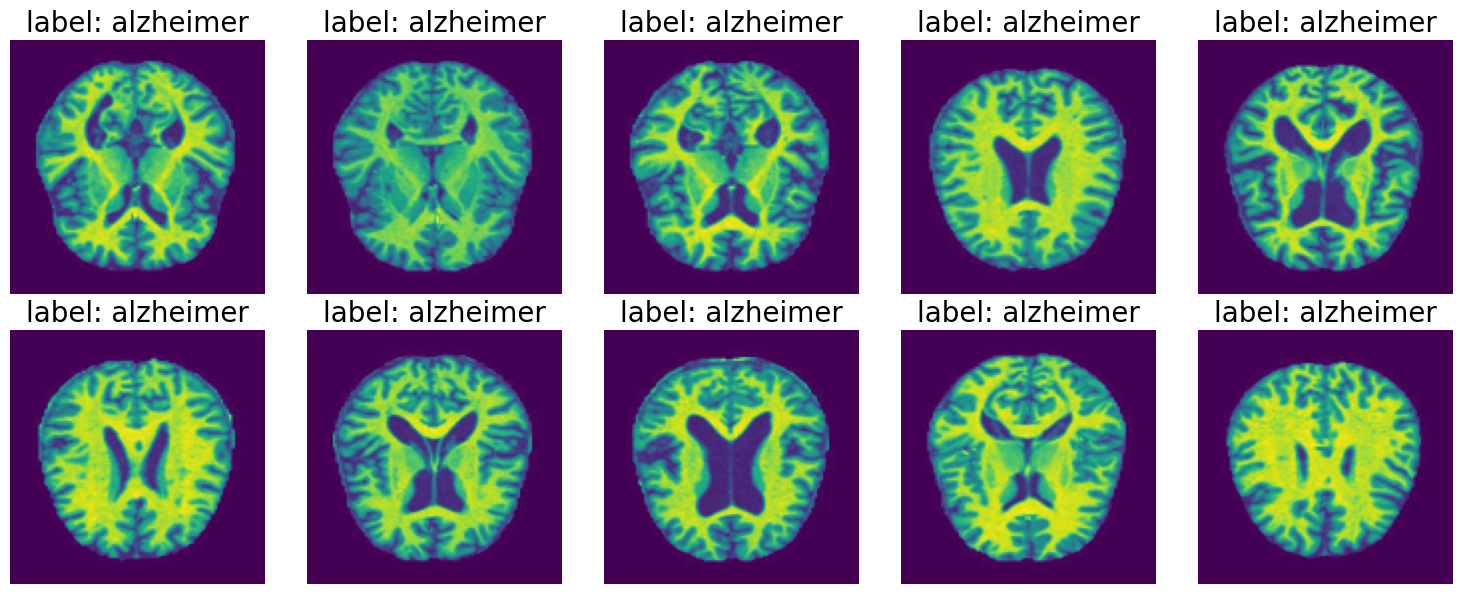

In [12]:
import random
import matplotlib.pyplot as plt
from PIL import Image

random_indices = random.sample(range(len(train_paths)),10)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128,128))

  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"label: {train_labels[idx]}", fontsize=20)

plt.tight_layout()
plt.show()

Image preprocessing(helper function)

In [13]:

# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = le.fit_transform(train_labels)

print(train_labels[:10])


[0 0 0 0 0 0 0 0 0 0]


In [ ]:
import os
import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# -------------------------
# TRAIN DATA
# -------------------------
train_dir = r"C:\Users\kavya\medical_diagnosis_project\dataset\train"
train_paths = glob.glob(os.path.join(train_dir, "*", "*"))
train_labels = [os.path.basename(os.path.dirname(path)) for path in train_paths]

# -------------------------
# TEST DATA
# -------------------------
test_dir = r"C:\Users\kavya\medical_diagnosis_project\dataset\test"
test_paths = glob.glob(os.path.join(test_dir, "*", "*"))
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_paths]

# -------------------------
# ENCODE LABELS
# -------------------------
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)

num_classes = len(le.classes_)

# -------------------------
# D A T A G E N
# -------------------------
IMAGE_SIZE = 128

def datagen(paths, labels, batch_size=32):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            images = []
            for path in batch_paths:
                img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
                img = img_to_array(img)
                img = preprocess_input(img)
                images.append(img)

            yield np.array(images), np.array(batch_labels)

# -------------------------
# 3. Model architecture
# -------------------------
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 3
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# -------------------------
# TRAIN
# -------------------------
batch_size = 20
epochs = 60

history = model.fit(
    datagen(train_paths, train_labels_encoded, batch_size),
    steps_per_epoch=len(train_paths)//batch_size,
    validation_data=datagen(test_paths, test_labels_encoded, batch_size),
    validation_steps=len(test_paths)//batch_size,
    epochs=epochs
)




In [54]:
import numpy as np
import cv2
import random

def datagen(paths, labels, batch_size, img_size=128):
    while True:
        # Shuffle each epoch
        combined = list(zip(paths, labels))
        random.shuffle(combined)
        paths, labels = zip(*combined)

        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            images = []
            final_labels = []

            for (p, l) in zip(batch_paths, batch_labels):
                img = cv2.imread(p)
                if img is None:
                    print("❌ Cannot read image:", p)
                    continue  # Skip corrupt image

                try:
                    img = cv2.resize(img, (img_size, img_size))
                except:
                    print("❌ Resize error:", p)
                    continue

                img = img.astype("float32") / 255.0

                images.append(img)
                final_labels.append(l)

            if len(images) == 0:
                continue  # skip empty batch

            X = np.array(images, dtype="float32")
            y = np.array(final_labels, dtype="int32")

            yield X, y


In [55]:
import numpy as np
import cv2
import random

def datagen(paths, labels, batch_size, img_size=128):
    while True:
        # Shuffle every epoch
        combined = list(zip(paths, labels))
        random.shuffle(combined)
        paths, labels = zip(*combined)

        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            images = []
            for p in batch_paths:
                img = cv2.imread(p)

                if img is None:
                    print("ERROR: Cannot read:", p)
                    continue  # Skip corrupted file

                img = cv2.resize(img, (img_size, img_size))
                img = img.astype("float32") / 255.0  # Normalize
                images.append(img)

            if len(images) == 0:
                continue

            X = np.array(images)
            y = np.array(batch_labels)

            yield X, y


TRAIN & VAL PLOTS

---



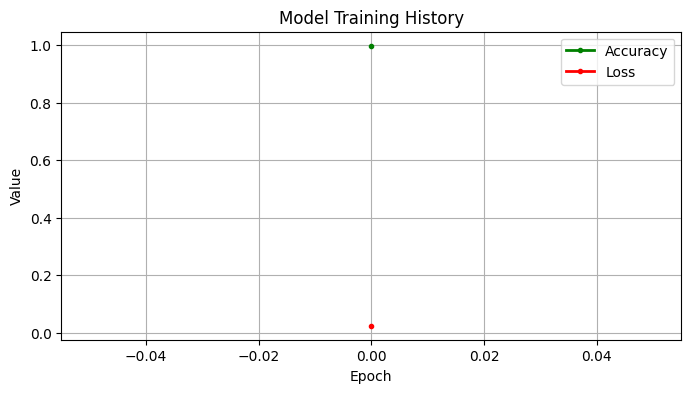

In [62]:
plt.figure(figsize=(8,4))
plt.grid(True)

acc_key = 'sparse_categorical_accuracy' if 'sparse_categorical_accuracy' in history.history else 'accuracy'

plt.plot(history.history[acc_key], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)

plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Accuracy', 'Loss'])
plt.show()


MODEL CLASSIFICATION REPORT

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np
import cv2
import numpy as np


def load_image(path):
    image = cv2.imread(path)

    # Detect unreadable images
    if image is None:
        print(f"[ERROR] Unable to load image: {path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image.astype('float32') / 255.0
    return image


def open_images(image_paths):
    images = []
    for path in image_paths:
        img = load_image(path)
        if img is None:
            continue  # skip bad images
        images.append(img)
    return np.array(images)


test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 776ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3355
           1       0.00      0.00      0.00         0

    accuracy                           0.82      3355
   macro avg       0.50      0.41      0.45      3355
weighted avg       1.00      0.82      0.90      3355



c:\Users\kavya\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kavya\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kavya\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [22]:
import cv2
import numpy as np

def load_image(path):
    image = cv2.imread(path)
    if image is None:
        raise ValueError(f"Cannot read image: {path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image.astype('float32') / 255.0
    return image


In [23]:
def open_images(image_paths):
    images = []
    for path in image_paths:
        image = load_image(path)
        image = augment_image(image)
        image = image.astype('float32')   # <— reduce memory by 50%
        images.append(image)
    
    return np.array(images, dtype='float32')


In [24]:


# 1. Encode labels
le = LabelEncoder()
test_labels_encoded = le.fit_transform(test_labels)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Encode training labels
train_labels_encoded = le.fit_transform(train_labels)

# Encode test labels using the SAME encoder
test_labels_encoded = le.transform(test_labels)


MODEL CONFUSION PLOT

In [25]:
# 3. Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

pred_classes = np.argmax(test_predictions, axis=1)

conf_matrix = confusion_matrix(test_labels_encoded, pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[2744  611]
 [   0    0]]


In [26]:
from sklearn.preprocessing import LabelEncoder

# Encode test labels
le = LabelEncoder()
test_labels_encoded = le.fit_transform(test_labels)



ROC CURVE PLOT

c:\Users\kavya\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_ranking.py:1192: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\kavya\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\kavya\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


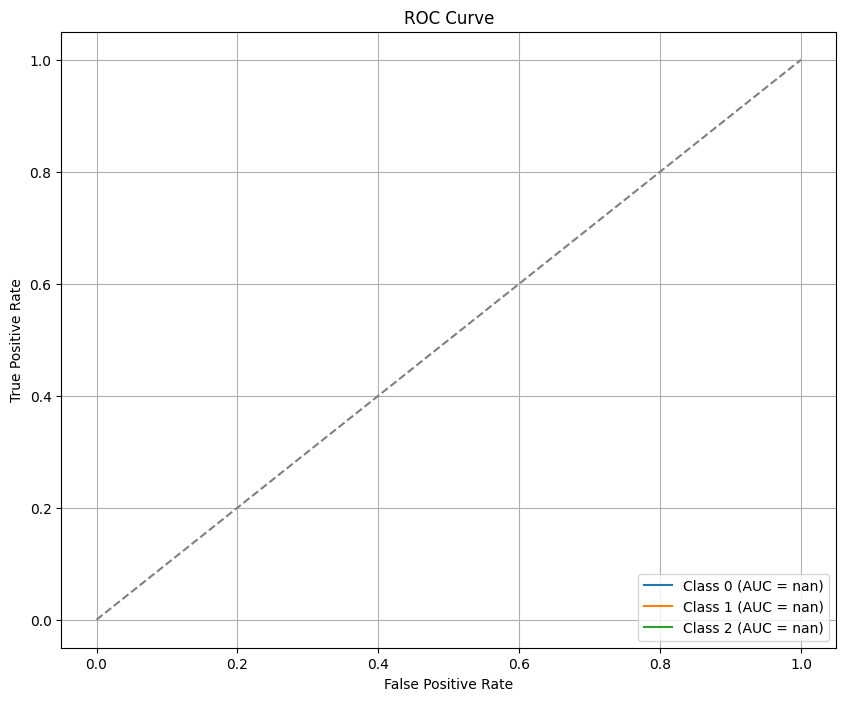

In [27]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------------
# 1. Encode test labels
# ---------------------------
le = LabelEncoder()
test_labels_encoded = le.fit_transform(test_labels)

# ---------------------------
# 2. Binarize labels
# ---------------------------
num_classes = len(os.listdir(train_dir))
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(num_classes))

# test_predictions = model.predict(X_test)
test_predictions_bin = test_predictions

# ---------------------------
# 3. ROC + AUC
# ---------------------------
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ---------------------------
# 4. Plot ROC
# ---------------------------
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


SAVE AND LOAD MODEL

In [28]:
# Save the entire model
model.save('model.h5')

In [29]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

MRI TUMOUR DETECTION SYSTEM


In [30]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented','YesTumour','Notumor']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor","No Alzheimer"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [31]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'
detect_and_display(image_path, model)

Error processing the image: [Errno 2] No such file or directory: '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'


In [32]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0004.jpg'
detect_and_display(image_path, model)

Error processing the image: [Errno 2] No such file or directory: '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0004.jpg'


In [33]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'
detect_and_display(image_path, model)

Error processing the image: [Errno 2] No such file or directory: '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'


In [34]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg'
detect_and_display(image_path, model)

Error processing the image: [Errno 2] No such file or directory: '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg'


In [35]:
!pip install flask tensorflow
from flask import Flask
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image


In [36]:
model = tf.keras.models.load_model("model.h5")


In [37]:
model.output_shape


(None, 3)

In [38]:
!pip install flask



In [39]:
from PIL import Image
import numpy as np

def predict_tumor(image):
    # Save the uploaded image to a temp file (or use in-memory if your model supports it)
    image.save("/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg")  # Save the image locally
    result = detect_and_display("/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg", model)
    return result  # This should return a string or image (modify if needed)


In [40]:
from PIL import Image
import cv2

def predict_tumor(image):

    save_path = r"C:\Users\kavya\medical_diagnosis_project1\dataset\alzheimer_dataset\test\MildDemented\1 (2).jpg"

    # Save uploaded image
    image.save(save_path)

    # Dummy model output (replace with real prediction)
    label = "MildDemented"
    confidence = 99.32

    # Load the image with OpenCV
    img = cv2.imread(save_path)

    # Overlay prediction text
    text = f"{label} ({confidence:.2f}%)"
    cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2)

    # Save modified image
    cv2.imwrite(save_path, img)

    # Return as PIL Image
    return Image.open(save_path)


In [3]:
!pip install gTTS


  Using cached gTTS-2.5.4-py3-none-any.whl.metadata (4.1 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
Using cached gTTS-2.5.4-py3-none-any.whl (29 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)

   -------------------- ------------------- 1/2 [gTTS]
   ---------------------------------------- 2/2 [gTTS]



In [42]:
pip install playsound


Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
from flask import Flask, request, render_template
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

app = Flask(__name__)

# Folder to save uploaded images
UPLOAD_FOLDER = "static/uploads"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)   # <-- FIX: Create folder if not exists
app.config["UPLOAD_FOLDER"] = UPLOAD_FOLDER

# Load trained model
MODEL_PATH = ".\model.h5"
model = load_model(MODEL_PATH)

# Class labels (must match your model output units)
class_names = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented",
    "yes",
    "no"
]

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

@app.route("/")
def home():
    return render_template("index.html")

@app.route("/predict", methods=["POST"])
def predict():
    if "image" not in request.files:
        return "No file uploaded"

    file = request.files["image"]
    if file.filename == "":
        return "No selected file"

    # Save uploaded image
    file_path = os.path.join(app.config["UPLOAD_FOLDER"], file.filename)
    file.sa


In [44]:
import os

for root, dirs, files in os.walk(".", topdown=True):
    for file in files:
        if file.endswith(".h5"):
            print(os.path.join(root, file))


.\model.h5


In [5]:
!pip install gradio tensorflow
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

  Using cached gradio-6.2.0-py3-none-any.whl.metadata (16 kB)
  Using cached gradio_client-2.0.2-py3-none-any.whl.metadata (7.1 kB)
Using cached gradio-6.2.0-py3-none-any.whl (23.0 MB)
Using cached gradio_client-2.0.2-py3-none-any.whl (55 kB)

   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   -------------------- ------------------- 1/2 [gradio]
   ------------

c:\Users\kavya\anaconda3\envs\cpu_dl_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = tf.keras.models.load_model(".\model.h5")

In [4]:
model.output_shape

(None, 3)

In [6]:
!pip install gradio

In [7]:
from PIL import Image
import numpy as np

def predict_tumor(image):
    # Save the uploaded image to a temp file (or use in-memory if your model supports it)
    image.save("/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg")  # Save the image locally
    result = detect_and_display("/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg", model)
    return result  # This should return a string or image (modify if needed)
 

   

In [8]:
from PIL import Image
import cv2

def predict_tumor(image):
    # Save uploaded image
    image.save("/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0000.jpg")

    # Call your model logic (replace this with your real model call)
    label = "meningioma"
    confidence = 99.32

    # Load the image with OpenCV
    img = cv2.imread("/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0000.jpg")

    # Overlay prediction text
    text = f"Tumor: {label} ({confidence:.2f}%)"
    cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2)

    # Save output image
    output_path = "/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0000.jpg"
    cv2.imwrite(output_path, img)

    # Return image using PIL
    return Image.open(output_path)

In [9]:
!pip install gTTS

In [10]:
pip install playsound

Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


In [1]:
import gradio as gr
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from gtts import gTTS
import tempfile
from tensorflow.keras.optimizers import Adam

# Load model
model = load_model("model.h5")
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

precautions = {
    "glioma": "Consult a neurologist immediately. Avoid radiation exposure and follow up with regular MRI scans.",
    "meningioma": "Schedule regular check-ups. Maintain hydration and a balanced diet. Avoid stress.",
    "pituitary": "Monitor hormonal levels. Consult an endocrinologist for hormone therapy if required.",
    "notumor": "No tumor detected. Maintain a healthy lifestyle and follow up only if symptoms persist."
}

recommended_actions = {
    "glioma": "Schedule an appointment with a neurologist immediately and discuss possible surgery or therapy options.",
    "meningioma": "Monitor tumor growth via regular MRI scans and maintain a healthy lifestyle.",
    "pituitary": "Consult an endocrinologist for hormonal therapy and regular check-ups.",
    "notumor": "Continue routine health check-ups and maintain a balanced lifestyle."
}

insights = {
    "glioma": "Gliomas grow inside brain tissue. Early neurological consultation is recommended.",
    "meningioma": "Meningiomas form around brain membranes. Maintain hydration and regular checkups.",
    "pituitary": "Pituitary tumors affect hormones. Check hormonal balance and vision changes.",
    "notumor": "No visible tumor detected. Maintain healthy lifestyle and follow up if symptoms persist."
}

# Helper Functions
def ai_insight(tumor_type, stage, confidence):
    return (
        f"Stage: {stage}\n"
        f"Confidence: {confidence}\n"
        f"Precaution: {precautions[tumor_type]}\n"
        f"Recommended Action: {recommended_actions[tumor_type]}\n\n"
        f"AI Analysis: {insights[tumor_type]}"
    )

def predict_simple(img):
    img = img.convert("RGB").resize((128,128))
    arr = img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    preds = model.predict(arr)
    idx = np.argmax(preds)
    conf = float(np.max(preds))
    label = class_labels[idx]

    stage = "Advanced Stage" if conf > 0.85 else "Moderate Stage" if conf > 0.65 else "Early Stage"

    simple = f"Tumor: {label} | Confidence: {conf*100:.2f}%"
    detail = ai_insight(label, stage, f"{conf*100:.2f}%")

    return simple, detail

def generate_voice(text):
    tts = gTTS(text)
    temp = tempfile.NamedTemporaryFile(delete=False, suffix=".mp3")
    tts.save(temp.name)
    return temp.name


# Gradio Interface
with gr.Blocks() as demo:

    stored_detailed = gr.State()
    stored_audio = gr.State()

    with gr.Row():

        # ========== STEP 1 ==========
        with gr.Column() as step1:
            gr.Markdown("## Step 1: Upload MRI Image")
            img_input = gr.Image(type="pil")
            btn_predict = gr.Button("Predict")
            simple_output = gr.Textbox(label="Simple Prediction", interactive=False)
            btn_next = gr.Button("Next", visible=False)

        # ========== STEP 2 ==========
        with gr.Column(visible=False) as step2:
            gr.Markdown("## Step 2: Detailed Prediction Results")
            detailed_output = gr.Textbox(interactive=False, lines=15)
            audio_output = gr.Audio(type="filepath")
            btn_back = gr.Button("Back")

    # --- Prediction Function ---
    def run_prediction(img):
        simple, detailed = predict_simple(img)
        audio = generate_voice(detailed)
        return simple, detailed, audio, gr.update(visible=True)

    btn_predict.click(
        run_prediction,
        inputs=img_input,
        outputs=[simple_output, stored_detailed, stored_audio, btn_next]
    )

    # --- NEXT Button: Show Step 2 Automatically ---
    def show_step2(detailed, audio):
        return (
            gr.update(visible=False),   # hide step1
            gr.update(visible=True),    # show step2
            detailed,                   # load stored detailed result
            audio                       # load stored audio
        )

    btn_next.click(
        show_step2,
        inputs=[stored_detailed, stored_audio],
        outputs=[step1, step2, detailed_output, audio_output]
    )

    # --- BACK Button ---
    btn_back.click(
        lambda: (gr.update(visible=True), gr.update(visible=False)),
        inputs=None,
        outputs=[step1, step2]
    )

demo.launch(share=True)

c:\Users\kavya\anaconda3\envs\cpu_dl_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c264e8a778ed4afff1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
